# Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from matplotlib.pyplot import imshow, imsave
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import datetime
import os, sys
import time
import pandas as pd

from matplotlib.pyplot import imshow, imsave
from plotly.subplots import make_subplots
import plotly.express as px
%matplotlib inline
import shutil

from google.colab import drive
import os

# gdrive_path='/content/gdrive/MyDrive/Capstone thesis Anahit/GANS - implementations/GANs/collect_into_one_architecture/'
gdrive_path='/content/gdrive/MyDrive/GANs/collect_into_one_architecture'

drive.mount('/content/gdrive', force_remount=True)
os.chdir(gdrive_path)
print(sorted(os.listdir()))


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/gdrive
['Changing_batchnorm_False.ipynb', 'Changing_batchnorm_True.ipynb', 'Changing_betas.ipynb', 'Changing_clip_values.ipynb', 'Changing_disc_iter.ipynb', 'Changing_gradient_penalty.ipynb', 'Changing_learning_rates.ipynb', 'Result-Plots.ipynb', '__pycache__', 'data', 'files', 'functions.py', 'functions_for_batchnorm.py', 'generated_images', 'real_images', 'results']


In [2]:
from functions import *

In [ ]:
values = pd.read_csv("files/values_of_some_hyperparams.csv")
values

Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0             0             0             0             0           0   
1             1             1             1             1           1   
2             2             2             2             2           2   
3             3             3             3             3           3   

    model_name  n_noise  batch_size  n_critic  max_epochs  clip_value  \
0         WGAN      100         128         1          35        0.01   
1      WGAN_GP      100         128         2          33         NaN   
2        LSGAN      100         128         1          20         NaN   
3  Vanilla_GAN      100         128         2          20         NaN   

   best_lr  best_beta  penalty  
0    0.001        0.9      NaN  
1    0.001        0.9     10.0  
2    0.001        0.9      NaN  
3    0.001        0.9      NaN

In [ ]:
# for digit in range(0,9):
#   digit = str(digit)
#   Generate_images_for_FID(digit = "0", model_path = ".", num_images = 500)

In [ ]:


# real_images_path = 'img'
# generated_images_path = 'img'
# batch_size = 64
# fid = calculate_fid_score(real_images_path, generated_images_path, batch_size)
# print(f"FID score: {fid}")

In [4]:
import random
random.seed(42) 
betas = []
for i in range(5):
    betas.append(random.random())
betas


[0.6394267984578837,
 0.025010755222666936,
 0.27502931836911926,
 0.22321073814882275,
 0.7364712141640124]

In [ ]:
def run(MODEL_NAME, lrs, batch_size, n_critic, max_epoch, clip_value, n_noise, threshold, beta, random_seed = True):
  
  time_to_finish = []
  root1 = f"results/models/beta/{MODEL_NAME}/"
  root2 = f"results/imgs/beta/{MODEL_NAME}/"
  for i in betas:
    start_time = time.time()
    path_model = root1 + "beta_" + str(i)
    path_img = root2 + "beta_" + str(i)

    if os.path.exists(path_img):
      shutil.rmtree(path_img)
      print(f"Removed {path_img}")
      os.mkdir(path_img)
    else:
      os.mkdir(path_img)
    
    if os.path.exists(path_model):
      shutil.rmtree(path_model)
      print(f"Removed {path_model}")
      os.mkdir(path_model)

    else:
      os.mkdir(path_model)
    print(path_model)
    print(path_img)
    print("*"*30)
    print("\n Training Beta = ", i, "!")
    if MODEL_NAME == "Vanilla_GAN":
      train_Vanilla_GAN(model_name = MODEL_NAME, path_model = f"{path_model}", path_img = f"{path_img}",
                learning_rate = lrs, batch_size = batch_size, n_critic = n_critic,  max_epoch = max_epoch, n_noise = n_noise, random_seed = random_seed, 
                threshold = threshold, beta=i)
    elif MODEL_NAME == "LSGAN":
      train_LSGAN(model_name = MODEL_NAME, path_model = f"{path_model}", path_img = f"{path_img}",
              learning_rate = lrs, batch_size = batch_size, n_critic = n_critic,  max_epoch = max_epoch, n_noise = n_noise, random_seed = random_seed,
              threshold = threshold, beta=i)
    elif  MODEL_NAME == "WGAN":
      train_WGAN(model_name = MODEL_NAME, path_model = f"{path_model}", path_img = f"{path_img}",
              learning_rate = lrs, batch_size = batch_size, n_critic = n_critic,  max_epoch = max_epoch, clip_value = clip_value, n_noise = n_noise,
              random_seed = random_seed, threshold = threshold, beta=i)
    elif MODEL_NAME == "WGAN_GP":
      train_WGAN_GP(model_name = MODEL_NAME, path_model = f"{path_model}", path_img = f"{path_img}",
              learning_rate = lrs, batch_size = batch_size, n_critic = n_critic,  max_epoch = max_epoch, n_noise = n_noise, random_seed = random_seed,
              threshold = threshold, beta=i)
    end_time = time.time()
    
    print("*"*30)
    time_to_finish.append(end_time - start_time)
  print("RUN TIME: ", time_to_finish)

  result_time = pd.DataFrame()
  result_time["time"] = time_to_finish
  result_time["beta"] = betas
  result_time["beta"] = result_time["beta"].astype('str')
  result_time.to_csv(f"results/models/beta/{MODEL_NAME}_runing_times.csv")

# GANs Comparative Analysis

# Beta Analysis

## Vanilla GAN beta Change 


In [ ]:
MODEL_NAME = values[values.model_name=="Vanilla_GAN"].model_name.values[0]
n_noise = values[values.model_name=="Vanilla_GAN"].n_noise.values[0]
batch_size = int(values[values.model_name=="Vanilla_GAN"].batch_size.values[0])
n_critic = values[values.model_name=="Vanilla_GAN"].n_critic.values[0]
max_epoch = values[values.model_name=="Vanilla_GAN"].max_epochs.values[0]
clip_value = values[values.model_name=="Vanilla_GAN"].clip_value.values[0]
lr = values[values.model_name=="Vanilla_GAN"].best_lr.values[0]

In [ ]:
# run(
#   MODEL_NAME = MODEL_NAME,
#   lrs = lr,
#   batch_size = batch_size,
#   n_critic = n_critic,
#   max_epoch = max_epoch, 
#   clip_value = clip_value,
#   n_noise = n_noise,
#   threshold = 0.5,
#   beta = betas)

In [ ]:
beta_paths = (os.listdir("results/models/beta/Vanilla_GAN"))

In [ ]:
for beta in betas:
  print(f"{MODEL_NAME} beta = {beta}")
  plot_f1_precison_recall(f"results/models/beta/{MODEL_NAME}/beta_{beta}/Vanilla_GAN_G_D_loss_scores_per_epoch.csv")
  plot_loss(f"results/models/beta/{MODEL_NAME}/beta_{beta}/Vanilla_GAN_G_D_loss_scores_per_epoch.csv")

Vanilla_GAN beta = 0.6394267984578837


Vanilla_GAN beta = 0.025010755222666936


Vanilla_GAN beta = 0.27502931836911926


Vanilla_GAN beta = 0.22321073814882275


Vanilla_GAN beta = 0.7364712141640124


Vanilla_GAN, BETA = 0.6394267984578837


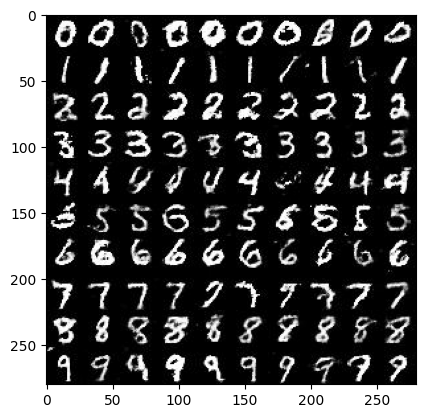

Vanilla_GAN, BETA = 0.025010755222666936


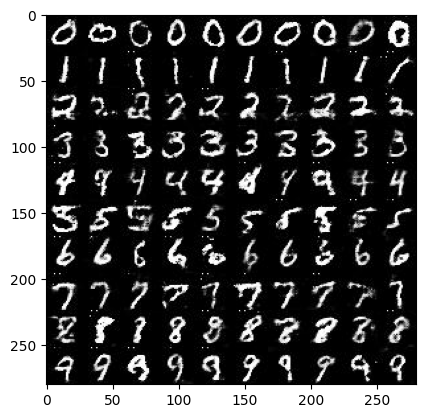

Vanilla_GAN, BETA = 0.27502931836911926


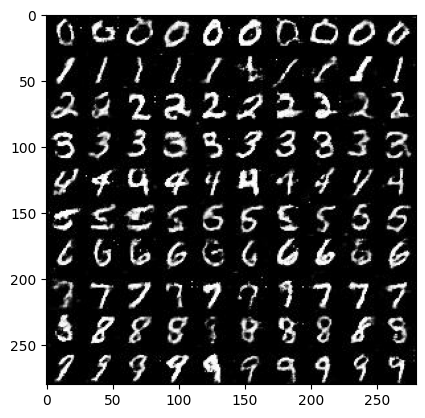

Vanilla_GAN, BETA = 0.22321073814882275


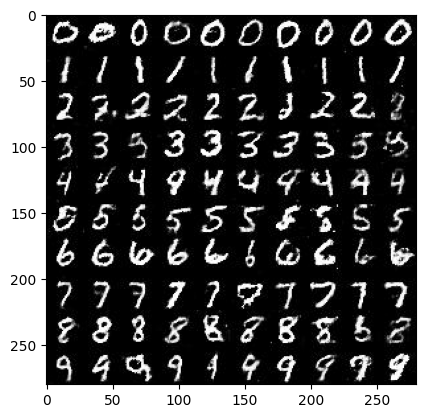

Vanilla_GAN, BETA = 0.7364712141640124


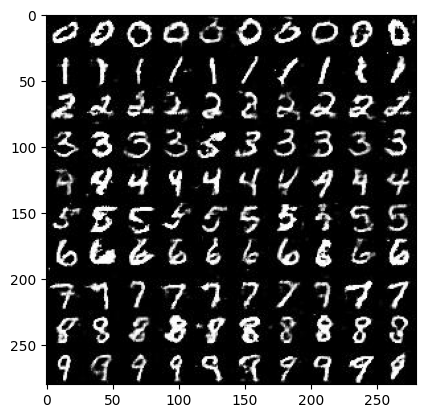

In [ ]:

for beta in betas:
  print(f"{MODEL_NAME}, BETA = {beta}")
  path = f"results/imgs/beta/{MODEL_NAME}/beta_{beta}/{MODEL_NAME}_last.jpg"
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.show()

# LSGAN

In [ ]:
MODEL_NAME = values[values.model_name=="LSGAN"].model_name.values[0]
n_noise = values[values.model_name=="LSGAN"].n_noise.values[0]
batch_size = int(values[values.model_name=="LSGAN"].batch_size.values[0])
n_critic = values[values.model_name=="LSGAN"].n_critic.values[0]
max_epoch = values[values.model_name=="LSGAN"].max_epochs.values[0]
clip_value = values[values.model_name=="LSGAN"].clip_value.values[0]
lr = values[values.model_name=="LSGAN"].best_lr.values[0]


In [ ]:
# run(
#   MODEL_NAME = MODEL_NAME,
#   lrs = lr,
#   batch_size = batch_size,
#   n_critic = n_critic,
#   max_epoch = max_epoch, 
#   clip_value = clip_value,
#   n_noise = n_noise,
#   threshold = 0.5,
#   beta = betas)

In [ ]:
for beta in betas:
  print(f"{MODEL_NAME} beta = {beta}")
  plot_f1_precison_recall(f"results/models/beta/{MODEL_NAME}/beta_{beta}/{MODEL_NAME}_G_D_loss_scores_per_epoch.csv")
  plot_loss(f"results/models/beta/{MODEL_NAME}/beta_{beta}/{MODEL_NAME}_G_D_loss_scores_per_epoch.csv")

LSGAN beta = 0.6394267984578837


LSGAN beta = 0.025010755222666936


LSGAN beta = 0.27502931836911926


LSGAN beta = 0.22321073814882275


LSGAN beta = 0.7364712141640124


LSGAN, BETA = 0.6394267984578837


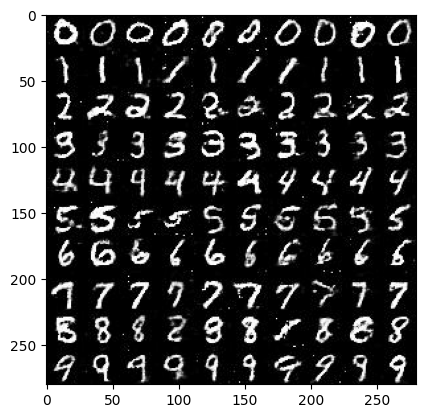

LSGAN, BETA = 0.025010755222666936


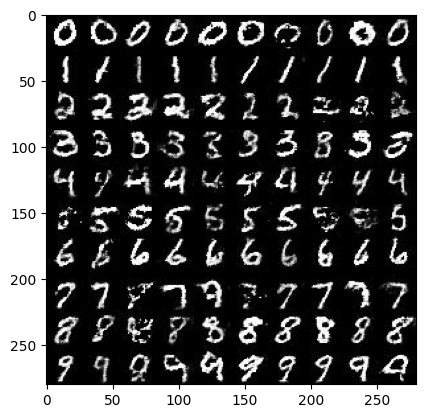

LSGAN, BETA = 0.27502931836911926


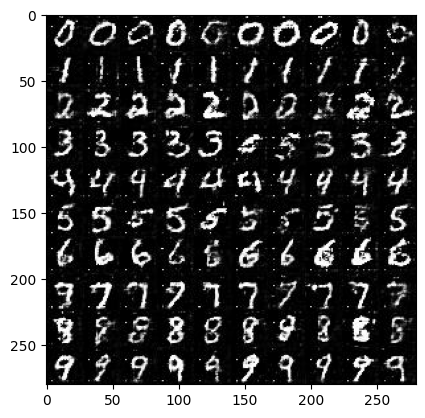

LSGAN, BETA = 0.22321073814882275


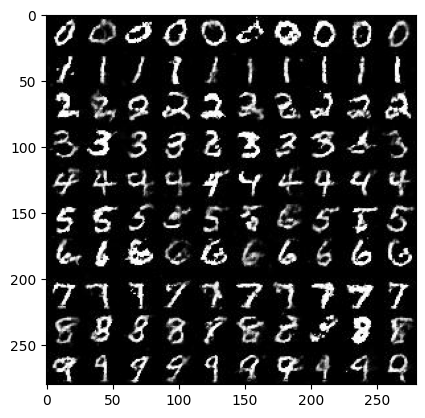

LSGAN, BETA = 0.7364712141640124


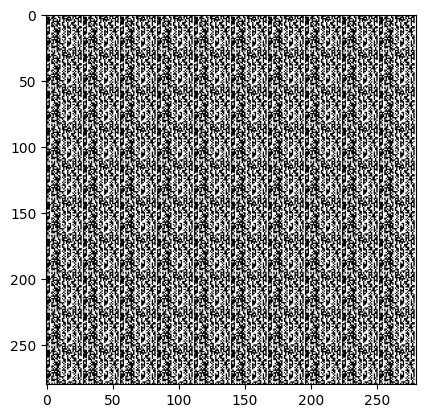

In [ ]:
for beta in betas:
  print(f"{MODEL_NAME}, BETA = {beta}")
  path = f"results/imgs/beta/{MODEL_NAME}/beta_{beta}/{MODEL_NAME}_last.jpg"
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.show()

# WGAN GP

In [ ]:
MODEL_NAME = values[values.model_name=="WGAN_GP"].model_name.values[0]
n_noise = values[values.model_name=="WGAN_GP"].n_noise.values[0]
batch_size = int(values[values.model_name=="WGAN_GP"].batch_size.values[0])
n_critic = values[values.model_name=="WGAN_GP"].n_critic.values[0]
max_epoch = values[values.model_name=="WGAN_GP"].max_epochs.values[0]
clip_value = values[values.model_name=="WGAN_GP"].clip_value.values[0]
lr = values[values.model_name=="WGAN_GP"].best_lr.values[0]


In [ ]:
# run(
#   MODEL_NAME = MODEL_NAME,
#   lrs = lr,
#   batch_size = batch_size,
#   n_critic = n_critic,
#   max_epoch = max_epoch, 
#   clip_value = clip_value,
#   n_noise = n_noise,
#   threshold = 0.5,
#   beta = betas
# )

In [ ]:
for beta in betas:
  print(f"{MODEL_NAME} beta = {beta}")
  plot_f1_precison_recall(f"results/models/beta/{MODEL_NAME}/beta_{beta}/{MODEL_NAME}_G_D_loss_scores_per_epoch.csv")
  plot_loss(f"results/models/beta/{MODEL_NAME}/beta_{beta}/{MODEL_NAME}_G_D_loss_scores_per_epoch.csv")

WGAN_GP beta = 0.6394267984578837


WGAN_GP beta = 0.025010755222666936


WGAN_GP beta = 0.27502931836911926


WGAN_GP beta = 0.22321073814882275


WGAN_GP beta = 0.7364712141640124


WGAN_GP, BETA = 0.6394267984578837


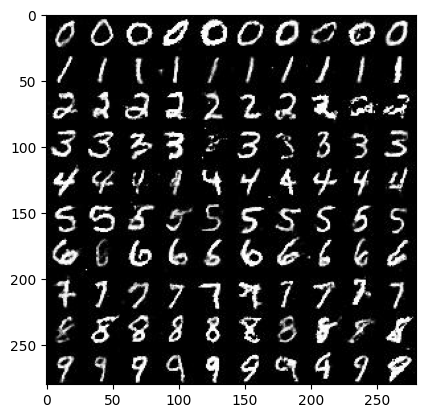

WGAN_GP, BETA = 0.025010755222666936


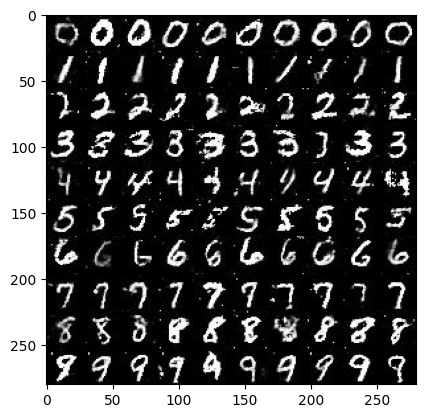

WGAN_GP, BETA = 0.27502931836911926


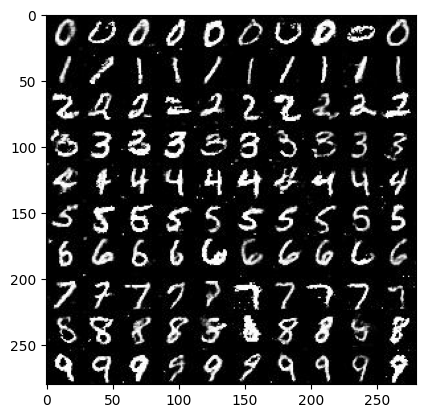

WGAN_GP, BETA = 0.22321073814882275


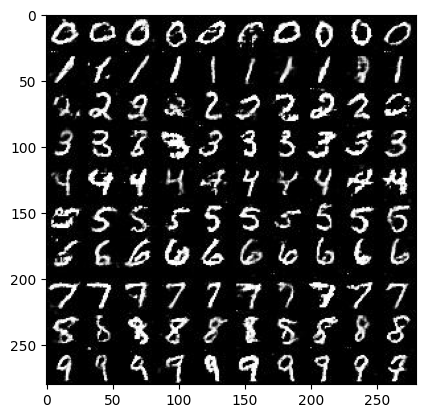

WGAN_GP, BETA = 0.7364712141640124


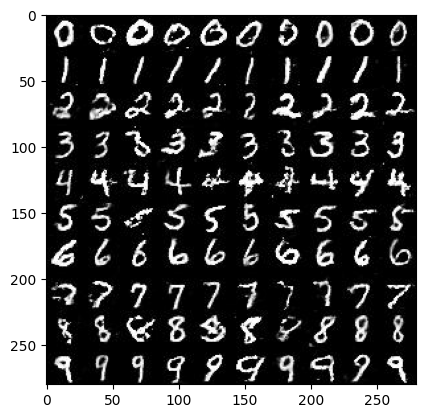

In [ ]:

for beta in betas:
  print(f"{MODEL_NAME}, BETA = {beta}")
  path = f"results/imgs/beta/{MODEL_NAME}/beta_{beta}/{MODEL_NAME}_last.jpg"
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.show()

# WGAN

In [ ]:
MODEL_NAME = values[values.model_name=="WGAN"].model_name.values[0]
n_noise = values[values.model_name=="WGAN"].n_noise.values[0]
batch_size = int(values[values.model_name=="WGAN"].batch_size.values[0])
n_critic = values[values.model_name=="WGAN"].n_critic.values[0]
max_epoch = values[values.model_name=="WGAN"].max_epochs.values[0]
clip_value = values[values.model_name=="WGAN"].clip_value.values[0]
lr = values[values.model_name=="WGAN"].best_lr.values[0]

Removed results/imgs/beta/WGAN/beta_0.27502931836911926
Removed results/models/beta/WGAN/beta_0.27502931836911926
results/models/beta/WGAN/beta_0.27502931836911926
results/imgs/beta/WGAN/beta_0.27502931836911926
******************************

 Training Beta =  0.27502931836911926 !
Starting the training WGAN
Batch size = 128, learning rate = 0.001
Beta = 0.27502931836911926
N critic = 1, N epochs = 35, Random Seed = True, Threshold = 0.5
Epoch: 0/35, D Loss: -4.834578990936279, G Loss: 1.1476473808288574
Epoch 0: Precision = 0.41754717283605747, Recall = 0.46582865915164084, F1 Score = 0.38865414281889793
Epoch: 1/35, D Loss: -8.201372146606445, G Loss: 13.318954467773438
Epoch 1: Precision = 0.5763971054410991, Recall = 0.5812633546554439, F1 Score = 0.5157960189107887
Epoch: 2/35, D Loss: -6.686239242553711, G Loss: -7.3475494384765625
Epoch 2: Precision = 0.5482078167882898, Recall = 0.4999332264566692, F1 Score = 0.47663485251326054
Epoch: 3/35, D Loss: -12.983560562133789, G Loss

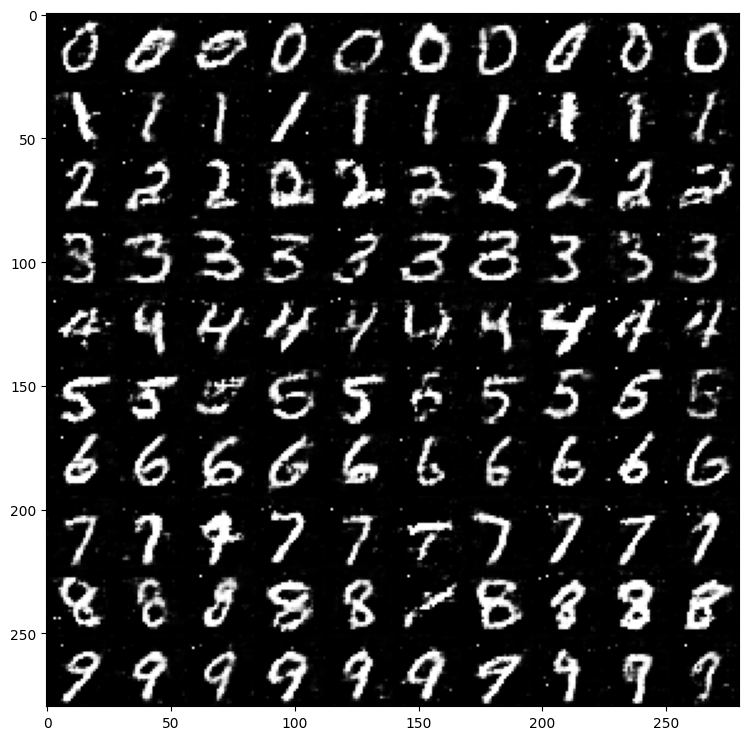

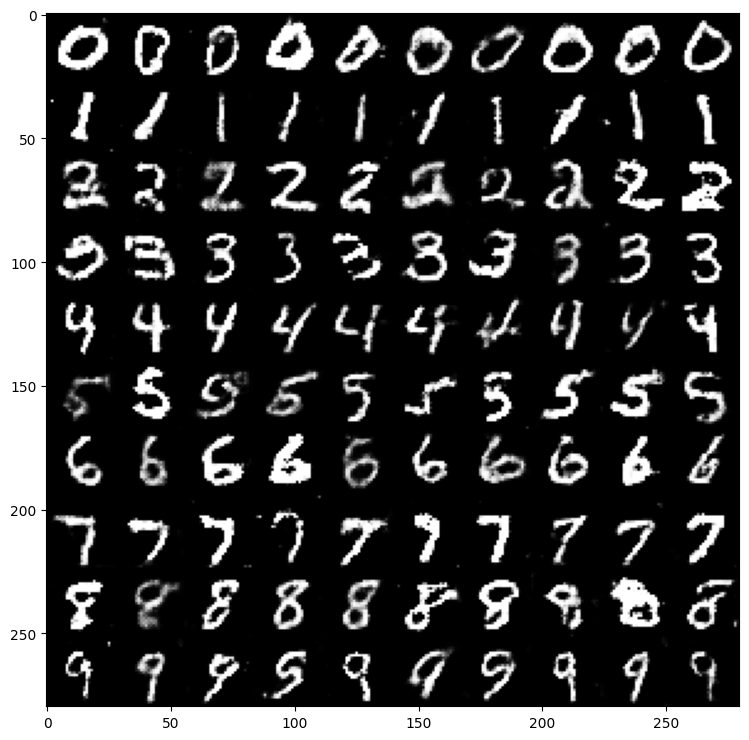

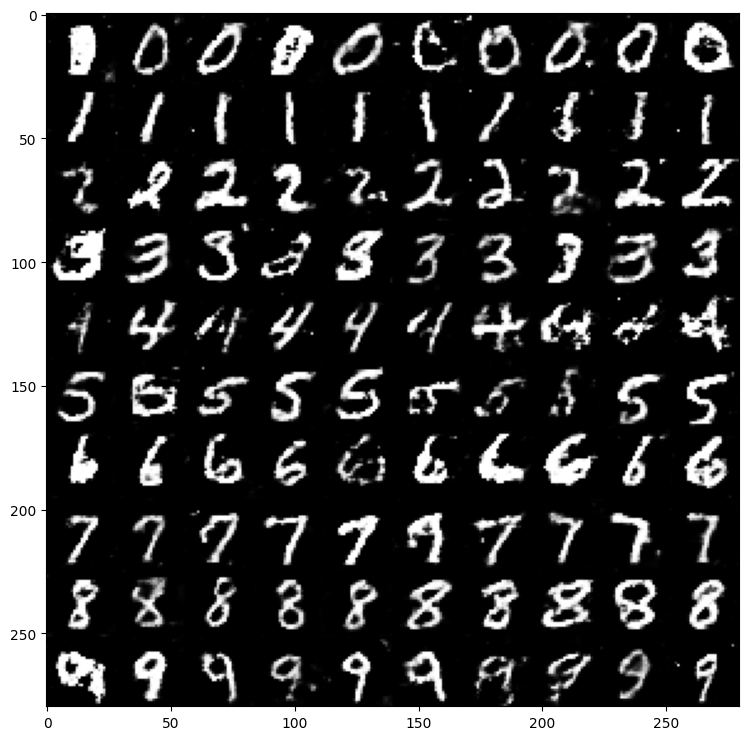

In [ ]:

# run(
#   MODEL_NAME = MODEL_NAME,
#   lrs = lr,
#   batch_size = batch_size,
#   n_critic = n_critic,
#   max_epoch = max_epoch, 
#   clip_value = clip_value,
#   n_noise = n_noise,
#   threshold = 0.5,
#   beta = betas)

In [ ]:
for beta in betas:
  print(f"{MODEL_NAME} beta = {beta}")
  plot_f1_precison_recall(f"results/models/beta/{MODEL_NAME}/beta_{beta}/{MODEL_NAME}_G_D_loss_scores_per_epoch.csv")
  plot_loss(f"results/models/beta/{MODEL_NAME}/beta_{beta}/{MODEL_NAME}_G_D_loss_scores_per_epoch.csv")

WGAN beta = 0.6394267984578837


WGAN beta = 0.025010755222666936


WGAN beta = 0.27502931836911926


WGAN beta = 0.22321073814882275


WGAN beta = 0.7364712141640124


WGAN, BETA = 0.6394267984578837


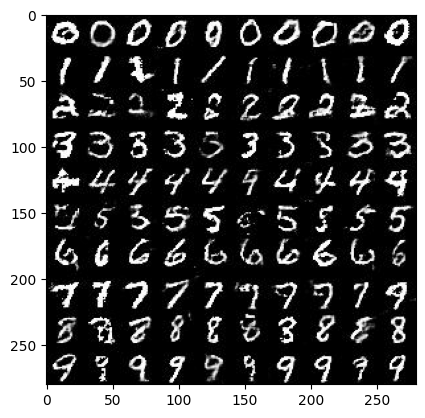

WGAN, BETA = 0.025010755222666936


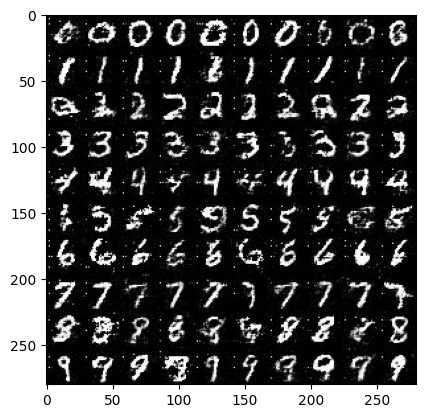

WGAN, BETA = 0.27502931836911926


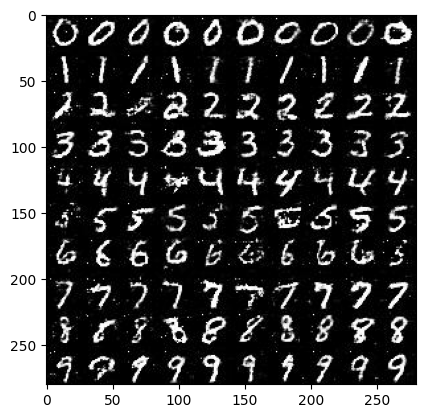

WGAN, BETA = 0.22321073814882275


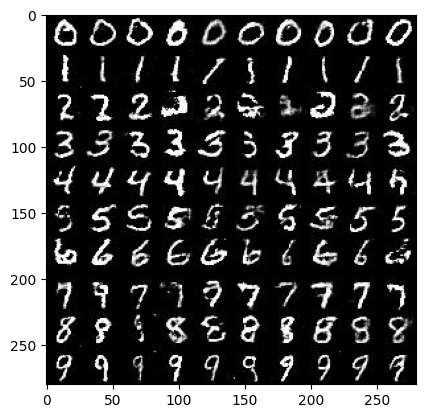

WGAN, BETA = 0.7364712141640124


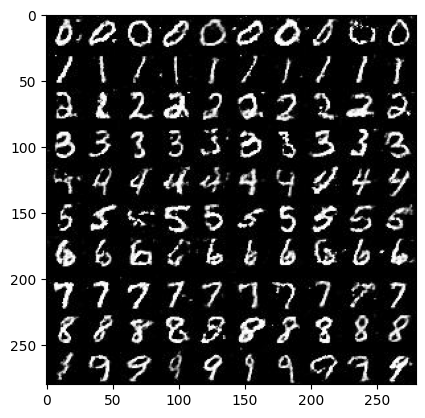

In [ ]:

for beta in betas:
  print(f"{MODEL_NAME}, BETA = {beta}")
  path = f"results/imgs/beta/{MODEL_NAME}/beta_{beta}/{MODEL_NAME}_last.jpg"
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.show()

# FID SCORE

## VANILLA GAN

In [5]:
MODEL_NAME = "Vanilla_GAN"
for beta in betas:
  path = f"generated_images/beta/{MODEL_NAME}/"
  add = "beta_" + str(beta)
  path = path + add
  model_path = f"results/models/beta/{MODEL_NAME}/" + add
  # print(model_path)
  if os.path.exists(path):
      shutil.rmtree(path)
      # print(f"removed {path}")
  os.mkdir(path)
  # print(f"created {path}")

  for digit in range(0,10):
    digit = str(digit)
    Generate_images_for_FID(digit = digit, model_path = model_path, num_images = 100, save_path = path)

    

In [6]:
fid_scores = []
for beta in betas:
  path = f"generated_images/beta/{MODEL_NAME}/"
  add = "beta_" + str(beta)
  path = path + add
  print(path)
  real_images_path = "real_images"
  generated_images_path = path
  batch_size = 20
  fid = calculate_fid_score(real_images_path, generated_images_path, batch_size)
  print(f"FID score: {fid}")
  fid_scores.append(fid)
  

fid_df = pd.DataFrame()
fid_df["fid_score"] = fid_scores
fid_df["model_name"] = MODEL_NAME
fid_df["beta"] = betas
fid_df.to_csv(f"results/models/beta/{MODEL_NAME}_FID_scores_vs_beta.csv")
fid_df

generated_images/beta/Vanilla_GAN/beta_0.6394267984578837


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 198MB/s]


FID score: 104.97505320702794
generated_images/beta/Vanilla_GAN/beta_0.025010755222666936
FID score: 93.14487070945268
generated_images/beta/Vanilla_GAN/beta_0.27502931836911926
FID score: 85.33423314579369
generated_images/beta/Vanilla_GAN/beta_0.22321073814882275
FID score: 87.66803162871722
generated_images/beta/Vanilla_GAN/beta_0.7364712141640124
FID score: 90.70900259101967


fid_score   model_name      beta
0  104.975053  Vanilla_GAN  0.639427
1   93.144871  Vanilla_GAN  0.025011
2   85.334233  Vanilla_GAN  0.275029
3   87.668032  Vanilla_GAN  0.223211
4   90.709003  Vanilla_GAN  0.736471

## LSGAN

In [7]:
MODEL_NAME = "LSGAN"
for beta in betas:
  path = f"generated_images/beta/{MODEL_NAME}/"
  add = "beta_" + str(beta)
  path = path + add
  model_path = f"results/models/beta/{MODEL_NAME}/" + add
  # print(model_path)
  if os.path.exists(path):
      shutil.rmtree(path)
      # print(f"removed {path}")
  os.mkdir(path)
  # print(f"created {path}")

  for digit in range(0,10):
    digit = str(digit)
    Generate_images_for_FID(digit = digit, model_path = model_path, num_images = 100, save_path = path)

    

In [8]:
fid_scores = []
for beta in betas:
  path = f"generated_images/beta/{MODEL_NAME}/"
  add = "beta_" + str(beta)
  path = path + add
  print(path)
  real_images_path = "real_images"
  generated_images_path = path
  batch_size = 20
  fid = calculate_fid_score(real_images_path, generated_images_path, batch_size)
  print(f"FID score: {fid}")
  fid_scores.append(fid)
  

fid_df = pd.DataFrame()
fid_df["fid_score"] = fid_scores
fid_df["model_name"] = MODEL_NAME
fid_df["beta"] = betas
fid_df.to_csv(f"results/models/beta/{MODEL_NAME}_FID_scores_vs_beta.csv")
fid_df

generated_images/beta/LSGAN/beta_0.6394267984578837


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID score: 82.30883349791179
generated_images/beta/LSGAN/beta_0.025010755222666936
FID score: 99.54856252742275
generated_images/beta/LSGAN/beta_0.27502931836911926
FID score: 114.75245820587568
generated_images/beta/LSGAN/beta_0.22321073814882275
FID score: 82.3520104601215
generated_images/beta/LSGAN/beta_0.7364712141640124
FID score: 450.0687039389083


fid_score model_name      beta
0   82.308833      LSGAN  0.639427
1   99.548563      LSGAN  0.025011
2  114.752458      LSGAN  0.275029
3   82.352010      LSGAN  0.223211
4  450.068704      LSGAN  0.736471

## WGAN

In [9]:
MODEL_NAME = "WGAN"
for beta in betas:
  path = f"generated_images/beta/{MODEL_NAME}/"
  add = "beta_" + str(beta)
  path = path + add
  model_path = f"results/models/beta/{MODEL_NAME}/" + add
  # print(model_path)
  if os.path.exists(path):
      shutil.rmtree(path)
      # print(f"removed {path}")
  os.mkdir(path)
  # print(f"created {path}")

  for digit in range(0,10):
    digit = str(digit)
    Generate_images_for_FID(digit = digit, model_path = model_path, num_images = 100, save_path = path)

    

In [10]:
fid_scores = []
for beta in betas:
  path = f"generated_images/beta/{MODEL_NAME}/"
  add = "beta_" + str(beta)
  path = path + add
  print(path)
  real_images_path = "real_images"
  generated_images_path = path
  batch_size = 20
  fid = calculate_fid_score(real_images_path, generated_images_path, batch_size)
  print(f"FID score: {fid}")
  fid_scores.append(fid)
  

fid_df = pd.DataFrame()
fid_df["fid_score"] = fid_scores
fid_df["model_name"] = MODEL_NAME
fid_df["beta"] = betas
fid_df.to_csv(f"results/models/beta/{MODEL_NAME}_FID_scores_vs_beta.csv")
fid_df

generated_images/beta/WGAN/beta_0.6394267984578837


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID score: 72.86785423506552
generated_images/beta/WGAN/beta_0.025010755222666936
FID score: 114.07800407802927
generated_images/beta/WGAN/beta_0.27502931836911926
FID score: 96.79346788811313
generated_images/beta/WGAN/beta_0.22321073814882275
FID score: 79.66337039309863
generated_images/beta/WGAN/beta_0.7364712141640124
FID score: 75.30567302649666


fid_score model_name      beta
0   72.867854       WGAN  0.639427
1  114.078004       WGAN  0.025011
2   96.793468       WGAN  0.275029
3   79.663370       WGAN  0.223211
4   75.305673       WGAN  0.736471

## WGAN GP

In [13]:
MODEL_NAME = "WGAN_GP"
for beta in betas:
  path = f"generated_images/beta/{MODEL_NAME}/"
  add = "beta_" + str(beta)
  path = path + add
  model_path = f"results/models/beta/{MODEL_NAME}/" + add
  # print(model_path)
  if os.path.exists(path):
      shutil.rmtree(path)
      # print(f"removed {path}")
  os.mkdir(path)
  # print(f"created {path}")

  for digit in range(0,10):
    digit = str(digit)
    Generate_images_for_FID(digit = digit, model_path = model_path, num_images = 100, save_path = path)

    

In [14]:
fid_scores = []
for beta in betas:
  path = f"generated_images/beta/{MODEL_NAME}/"
  add = "beta_" + str(beta)
  path = path + add
  print(path)
  real_images_path = "real_images"
  generated_images_path = path
  batch_size = 20
  fid = calculate_fid_score(real_images_path, generated_images_path, batch_size)
  print(f"FID score: {fid}")
  fid_scores.append(fid)
  

fid_df = pd.DataFrame()
fid_df["fid_score"] = fid_scores
fid_df["model_name"] = MODEL_NAME
fid_df["beta"] = betas
fid_df.to_csv(f"results/models/beta/{MODEL_NAME}_FID_scores_vs_beta.csv")
fid_df

generated_images/beta/WGAN_GP/beta_0.6394267984578837


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID score: 81.62604250373312
generated_images/beta/WGAN_GP/beta_0.025010755222666936
FID score: 91.52471312464075
generated_images/beta/WGAN_GP/beta_0.27502931836911926
FID score: 73.72635768780557
generated_images/beta/WGAN_GP/beta_0.22321073814882275
FID score: 78.60477813793722
generated_images/beta/WGAN_GP/beta_0.7364712141640124
FID score: 70.86132321478328


fid_score model_name      beta
0  81.626043    WGAN_GP  0.639427
1  91.524713    WGAN_GP  0.025011
2  73.726358    WGAN_GP  0.275029
3  78.604778    WGAN_GP  0.223211
4  70.861323    WGAN_GP  0.736471

In [17]:
fid_df.to_csv(f"results/models/beta/{MODEL_NAME}_FID_scores_vs_beta.csv")

# Beta VS Loss

In [ ]:
def load_model_and_results(MODEL_NAME):
  trained_betas = os.listdir(f"results/models/beta/{MODEL_NAME}/")
  root = f"results/models/beta/{MODEL_NAME}/"
  G_loss_list = []
  D_loss_list = []


  for trained_betas, beta in zip(trained_betas, betas):
    print(f"BETA {beta}")
    path = root + trained_betas + "/"

    G_loss, D_loss = load_model(path, beta, n_noise)
    G_loss_list.append(G_loss.item())
    D_loss_list.append(D_loss.item())

    print("D = ",D_loss.item(), "G = ",G_loss.item())

  result_loss = pd.DataFrame()
  result_loss["D_loss"] = D_loss_list
  result_loss["G_loss"] = G_loss_list
  result_loss["beta"] = betas
  result_loss["beta"] = result_loss["beta"].astype('str')
  result_loss['size'] = 5
  result_loss.to_csv(f"results/models/beta/{MODEL_NAME}_loss_values.csv")
  print(result_loss)


  fig = make_subplots(rows=1, cols=2)

  fig.add_trace(px.scatter(result_loss, x="beta", y="D_loss",  size="size").data[0], row=1, col=1)
  fig.add_trace(px.scatter(result_loss, x="beta", y="G_loss",  size="size").data[0], row=1, col=2)
  fig.update_layout(title="Loss vs Beta", 
                    xaxis=dict(title="Beta"),
                    yaxis=dict(title="Loss"))

  fig.show()

  result_time = pd.read_csv(f"results/models/beta/{MODEL_NAME}_runing_times.csv")
  result_time["size"] = 5
  
  print(result_time)

  fig = px.scatter(result_time, x="beta", y="time", color="beta", size="size", title = "run time vs Beta")
  fig.show()  

### Vanilla GAN

In [ ]:
load_model_and_results("Vanilla_GAN")

BETA 0.6394267984578837
D =  1.3566323518753052 G =  0.7030379176139832
BETA 0.025010755222666936
D =  1.3855915069580078 G =  0.6575862765312195
BETA 0.27502931836911926
D =  1.3636066913604736 G =  0.6816613674163818
BETA 0.22321073814882275
D =  1.3840515613555908 G =  0.7287067174911499
BETA 0.7364712141640124
D =  0.658775806427002 G =  3.130321502685547
     D_loss    G_loss                  beta  size
0  1.356632  0.703038    0.6394267984578837     5
1  1.385592  0.657586  0.025010755222666936     5
2  1.363607  0.681661   0.27502931836911926     5
3  1.384052  0.728707   0.22321073814882275     5
4  0.658776  3.130322    0.7364712141640124     5


   Unnamed: 0         time      beta  size
0           0  1218.486906  0.639427     5
1           1  1203.864999  0.025011     5
2           2  1201.127067  0.275029     5
3           3  1202.452111  0.223211     5
4           4  1200.531295  0.736471     5


### LSGAN

In [ ]:
load_model_and_results("LSGAN")

BETA 0.6394267984578837
D =  0.19156047701835632 G =  0.4709712862968445
BETA 0.025010755222666936
D =  0.25171253085136414 G =  0.28106969594955444
BETA 0.27502931836911926
D =  0.09086264669895172 G =  0.2616811990737915
BETA 0.22321073814882275
D =  0.25103622674942017 G =  0.22177281975746155
BETA 0.7364712141640124
D =  0.0002991022483911365 G =  1.0308037996292114
     D_loss    G_loss                  beta  size
0  0.191560  0.470971    0.6394267984578837     5
1  0.251713  0.281070  0.025010755222666936     5
2  0.090863  0.261681   0.27502931836911926     5
3  0.251036  0.221773   0.22321073814882275     5
4  0.000299  1.030804    0.7364712141640124     5


   Unnamed: 0         time      beta  size
0           0  1401.843450  0.639427     5
1           1  1401.151581  0.025011     5
2           2  1399.535569  0.275029     5
3           3  1398.280157  0.223211     5
4           4  1390.297204  0.736471     5


### WGAN


In [ ]:
load_model_and_results("WGAN")


BETA 0.6394267984578837
D =  0.0031915903091430664 G =  1.5957626104354858
BETA 0.025010755222666936
D =  -158.85235595703125 G =  -457.66876220703125
BETA 0.27502931836911926
D =  -122.04583740234375 G =  549.952880859375
BETA 0.22321073814882275
D =  0.001178741455078125 G =  23.930505752563477
BETA 0.7364712141640124
D =  -18.762866973876953 G =  26.568449020385742
       D_loss      G_loss                  beta  size
0    0.003192    1.595763    0.6394267984578837     5
1 -158.852356 -457.668762  0.025010755222666936     5
2 -122.045837  549.952881   0.27502931836911926     5
3    0.001179   23.930506   0.22321073814882275     5
4  -18.762867   26.568449    0.7364712141640124     5


   Unnamed: 0         time      beta  size
0           0  2556.624054  0.275029     5
1           1  2568.851946  0.223211     5
2           2  2537.162249  0.736471     5


### WGAN_GP


In [ ]:
load_model_and_results("WGAN_GP")


BETA 0.6394267984578837
D =  0.15779048204421997 G =  -13.24859619140625
BETA 0.025010755222666936
D =  0.17380362749099731 G =  -10.565319061279297
BETA 0.27502931836911926
D =  0.06374320387840271 G =  -6.103922367095947
BETA 0.22321073814882275
D =  0.051180869340896606 G =  6.100637435913086
BETA 0.7364712141640124
D =  0.13422644138336182 G =  -20.740482330322266
     D_loss     G_loss                  beta  size
0  0.157790 -13.248596    0.6394267984578837     5
1  0.173804 -10.565319  0.025010755222666936     5
2  0.063743  -6.103922   0.27502931836911926     5
3  0.051181   6.100637   0.22321073814882275     5
4  0.134226 -20.740482    0.7364712141640124     5


   Unnamed: 0         time      beta  size
0           0  3220.361581  0.639427     5
1           1  3203.778056  0.025011     5
2           2  3207.498967  0.275029     5
3           3  3195.322885  0.223211     5
4           4  3188.630265  0.736471     5
